In [1]:
%cd '/home/aris/projects/grab_exp'

%load_ext autoreload
%autoreload 1

from IPython.display import display

/home/aris/projects/grab_exp


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
import pickle
from timeit import default_timer as timer
from tqdm.notebook import tqdm

In [3]:
def show_df(df: pd.DataFrame):
    display(df.head())
    print(df.shape)

In [4]:
import pandas as pd
import wandb

api = wandb.Api()

# runs = api.runs("grab/sam-cifar10")

sam-resnet-da_none-bn-backpack-mean


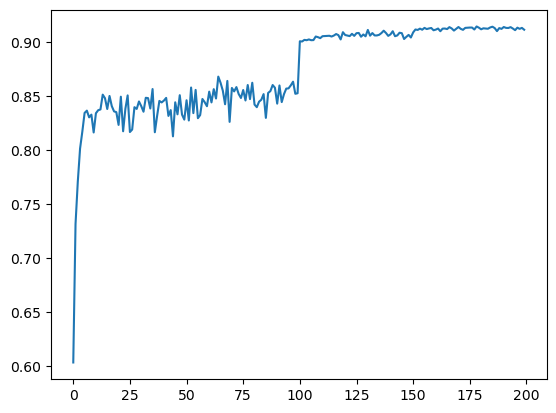

0.867900013923645
0.9110999703407288
0.9143000245094299


200

In [5]:
# run = api.run('grab/sam-cifar10/kfi65xoh')
run = api.run('grab/sam-cifar10/hyd0brf4')

print(run.name)
val_acc = run.history(keys=['val_acc'])['val_acc']

plt.plot(val_acc)
plt.show()

print(np.max(val_acc[:100]))
print(np.max(val_acc[100:-50]))
print(np.max(val_acc[-50:]))

len(val_acc)

resnet-da_basic-bn-backpack-pair


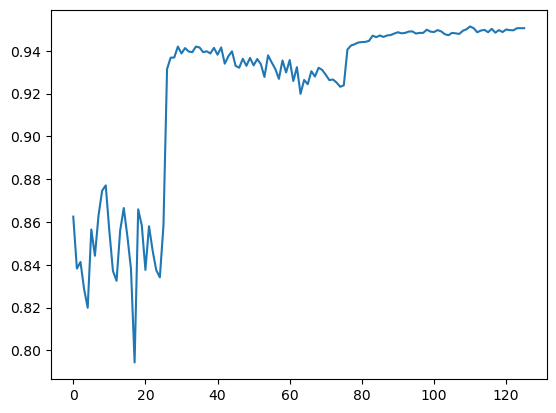

0.9498999714851379
0.9419999718666077
0.9513999819755554


In [15]:
run = api.run('grab/sam-cifar10/vcftch9k')

print(run.name)
val_acc = run.history(keys=['val_acc'])['val_acc']

plt.plot(val_acc)
plt.show()

print(np.max(val_acc[:100]))
print(np.max(val_acc[-100:-50]))
print(np.max(val_acc[-50:]))

In [20]:
data = []
for run in runs:
    if 'faulty' in run.tags:
        continue
    if 'result' not in run.tags:
        continue
    if run.config.get('model_name') != 'resnet':
        continue

    entry = {
        'data_aug': run.config['data_augmentation'],
    }

    # history = run.scan_history()
    if 'func' in run.name:
        # func version
        val_acc = run.history(keys=['val_accuracy'])['val_accuracy']

        entry['norm'] = run.config['wrn_norm']
        entry['grab'] = run.config['balance_type'] == 'BalanceType.MEAN_BALANCE'

        if run.config.get('exp') == 'sam':
            entry['sam'] = True
            entry['rho'] = run.config['rho']
        else:
            entry['sam'] = False
            entry['rho'] = 0
    else:
        # lightning version
        val_acc = run.history(keys=['val_acc'])['val_acc']

        entry['norm'] = run.config['norm']

        entry['rho'] = run.config['rho'] if 'rho' in run.config else 0
        # entry['grab'] = False

        if 'rho' in run.config:
            entry['sam'] = True
            entry['rho'] = run.config['rho']
        else:
            entry['sam'] = False
            entry['rho'] = 0

        entry['grab'] = False

    entry['val_acc_100'] = val_acc[:100].max()
    entry['val_acc_150'] = val_acc[100:-50].max()
    entry['val_acc_200'] = val_acc[-50:].max()
    entry['val_acc'] = val_acc.max()

    data.append(entry)

    print(entry)

df = pd.DataFrame(data)

df = df.sort_values(['data_aug', 'sam', 'rho', 'grab', 'norm'])

show_df(df)

{'data_aug': 'none', 'norm': 'gn', 'grab': True, 'sam': True, 'rho': 0.1, 'val_acc_100': 0.8628, 'val_acc_150': 0.8931, 'val_acc_200': 0.8955, 'val_acc': 0.8955}
{'data_aug': 'basic', 'norm': 'gn', 'grab': True, 'sam': True, 'rho': 0.3, 'val_acc_100': 0.9014, 'val_acc_150': 0.9388, 'val_acc_200': 0.9448, 'val_acc': 0.9448}
{'data_aug': 'basic', 'norm': 'gn', 'grab': True, 'sam': True, 'rho': 0.1, 'val_acc_100': 0.8938, 'val_acc_150': 0.9444, 'val_acc_200': 0.9491, 'val_acc': 0.9491}
{'data_aug': 'basic', 'norm': 'gn', 'grab': True, 'sam': True, 'rho': 0.2, 'val_acc_100': 0.9057, 'val_acc_150': 0.9437, 'val_acc_200': 0.9499, 'val_acc': 0.9499}
{'data_aug': 'basic', 'norm': 'bn', 'rho': 0.3, 'sam': True, 'grab': False, 'val_acc_100': 0.9172999858856201, 'val_acc_150': 0.9546999931335449, 'val_acc_200': 0.958299994468689, 'val_acc': 0.958299994468689}
{'data_aug': 'basic', 'norm': 'gn', 'rho': 0.2, 'sam': True, 'grab': False, 'val_acc_100': 0.897599995136261, 'val_acc_150': 0.941900014877

,data_aug,norm,grab,sam,rho,val_acc_100,val_acc_150,val_acc_200,val_acc
18,basic,bn,False,False,0.0,0.8747,0.9439,0.9522,0.9522
15,basic,gn,False,False,0.0,0.8725,0.9273,0.9411,0.9411
10,basic,gn,True,False,0.0,0.8690,0.9243,0.9400,0.9400
12,basic,bn,False,True,0.1,0.9054,0.9531,0.9579,0.9579
16,basic,gn,False,True,0.1,0.8983,0.9449,0.9531,0.9531


(19, 9)


In [19]:
df

,data_aug,norm,grab,sam,rho,val_acc_100,val_acc_150,val_acc_200,val_acc
18,basic,bn,False,False,0.0,0.8747,0.9439,0.9522,0.9522
15,basic,gn,False,False,0.0,0.8725,0.9273,0.9411,0.9411
10,basic,gn,True,False,0.0,0.8690,0.9243,0.9400,0.9400
12,basic,bn,False,True,0.1,0.9054,0.9531,0.9579,0.9579
16,basic,gn,False,True,0.1,0.8983,0.9449,0.9531,0.9531
2,basic,gn,True,True,0.1,0.8938,0.9444,0.9491,0.9491
7,basic,bn,False,True,0.2,0.9152,0.9576,0.9605,0.9605
5,basic,gn,False,True,0.2,0.8976,0.9419,0.9457,0.9457
3,basic,gn,True,True,0.2,0.9057,0.9437,0.9499,0.9499
4,basic,bn,False,True,0.3,0.9173,0.9547,0.9583,0.9583
